# Using less training and checking the results

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import skfuzzy as fuzz

## import ExtractRulesQPSO class
import sys, os
sys.path.append(os.getcwd() + '/scripts')

from importlib import reload
import ExtractRulesQPSO
reload(ExtractRulesQPSO)

import FuzzyClustering
reload(FuzzyClustering)

from ExtractRulesQPSO import ExtractRulesQPSO
from FuzzyClustering import FuzzyClustering
from FuzzyRule import FuzzyRule

def apply_fuzzy_clustering_traing_test(df, test_size):
    df_train, df_test = train_test_split(df, test_size=test_size)
    
    data_corrosive = []
    labels_corrosive = []
    for idx in range(df_train.shape[0]):
        tmp = np.array([df_train['x'].values[idx], df_train['y'].values[idx]])
        data_corrosive.append(tmp)
        labels_corrosive.append('Corrosive')

    data_corrosive = np.array(data_corrosive)


    data_immune = []
    labels_immune = []
    for idx in range(df_train.shape[0]):
        tmp = np.array([df_train['x.1'].values[idx], df_train['y.1'].values[idx]])
        data_immune.append(tmp)
        labels_immune.append('Immune')

    data_immune = np.array(data_immune)

    data_passive = []
    labels_passive = []
    for idx in range(df_train.shape[0]):
        tmp = np.array([df_train['x.2'].values[idx], df_train['y.2'].values[idx]])
        data_passive.append(tmp)
        labels_passive.append('Passive')

    data_passive = np.array(data_passive)
    
    fc_corrosive = FuzzyClustering(data_corrosive)
    fc_immune = FuzzyClustering(data_immune)
    fc_passive = FuzzyClustering(data_passive)
    
    # finding centers
    fc_corrosive.extractClusteringCenters()
    centers_corrosive = fc_corrosive.getDenormalizedClusterCenters()

    fc_immune.extractClusteringCenters()
    centers_immune = fc_immune.getDenormalizedClusterCenters()

    fc_passive.extractClusteringCenters()
    centers_passive = fc_passive.getDenormalizedClusterCenters()
    
    # Get all class centers
    all_class_centers = []
    all_class_centers.append(centers_corrosive)
    all_class_centers.append(centers_immune)
    all_class_centers.append(centers_passive)
    
    # Apply QPSO
    print('Running QPSO...')
    qpso = ExtractRulesQPSO(20, 50, 2 * (len(centers_corrosive) + len(centers_immune) + len(centers_passive)))
    qpso.solver([centers_corrosive, centers_immune, centers_passive], 
                [data_corrosive, data_immune, data_passive])
    
    tuned_stds = ExtractRulesQPSO._arrangeStds(qpso.best_particle, all_class_centers)
    stds_corrosive, stds_immune, stds_passive = tuned_stds
    
    class_labels = ['Corrosive', 'Immune', 'Passive']
    
    print('Running testing...')
    # Check testing data
    xs = []
    ys = []
    testing_labels = []

    test_data_corrosive = []
    for idx in range(df_test.shape[0]):
        tmp = np.array([df_test['x'].values[idx], df_test['y'].values[idx]])
        test_data_corrosive.append(tmp)

    test_data_corrosive = np.array(test_data_corrosive)

    test_data_immune = []
    for idx in range(df_test.shape[0]):
        tmp = np.array([df_test['x.1'].values[idx], df_test['y.1'].values[idx]])
        test_data_immune.append(tmp)

    test_data_immune = np.array(test_data_immune)

    test_data_passive = []
    for idx in range(df_test.shape[0]):
        tmp = np.array([df_test['x.2'].values[idx], df_test['y.2'].values[idx]])
        test_data_passive.append(tmp)

    test_data_passive = np.array(test_data_passive)
    
    for data_point in test_data_corrosive:
        xs.append(data_point[0])
        ys.append(data_point[1])
        testing_labels.append(
            ExtractRulesQPSO._returnClassWithMaxMF(all_class_centers, tuned_stds, data_point, class_labels)
        )


    for data_point in test_data_immune:
        xs.append(data_point[0])
        ys.append(data_point[1])
        testing_labels.append(
            ExtractRulesQPSO._returnClassWithMaxMF(all_class_centers, tuned_stds, data_point, class_labels)
        )

    for data_point in test_data_passive:
        xs.append(data_point[0])
        ys.append(data_point[1])
        testing_labels.append(
            ExtractRulesQPSO._returnClassWithMaxMF(all_class_centers, tuned_stds, data_point, class_labels)
        )
    
    actual_labels = labels_corrosive + labels_immune + labels_passive
    
    num_mis_labels = 0
    
    for modeled_label, actual_label in zip(testing_labels, actual_labels):
        if modeled_label != actual_label:
            num_mis_labels += 1
    
    num_clusters = [len(centers_corrosive), len(centers_immune), len(centers_passive)]
    
    return num_mis_labels / len(actual_labels), num_clusters


In [2]:
df = pd.read_csv('./data/data_extraction.csv', header=1)
df = df.dropna()
df.head()

,x,y,x.1,y.1,x.2,y.2
0,-1.513584,2.021725,-1.407596,-0.688274,2.236173,2.033473
1,-1.231298,2.011772,-1.159470,-0.651288,2.387670,1.929299
2,-1.247023,1.969969,-1.025865,-0.692831,2.306333,1.850828
3,-0.716827,2.007446,-1.539035,-0.751166,2.024913,1.819007
4,-0.831566,1.939361,-1.504118,-0.834656,2.194410,1.646978


## Applying fuzzy clustering to all data

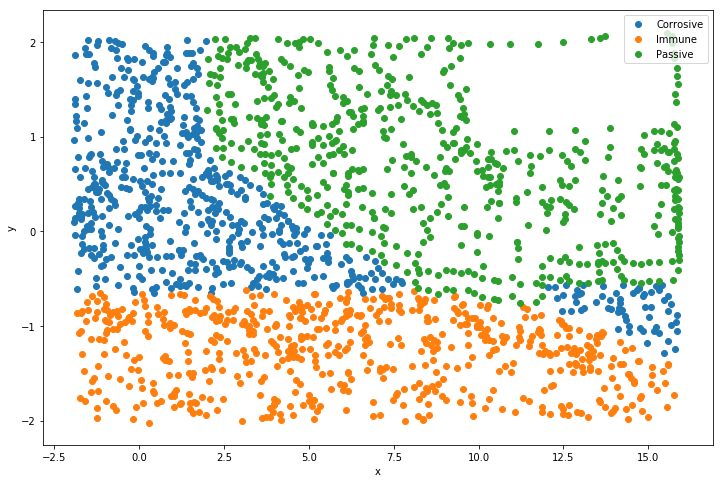

In [3]:
data_corrosive = []
for idx in range(df.shape[0]):
    tmp = np.array([df['x'].values[idx], df['y'].values[idx]])
    data_corrosive.append(tmp)

data_corrosive = np.array(data_corrosive)


data_immune = []
for idx in range(df.shape[0]):
    tmp = np.array([df['x.1'].values[idx], df['y.1'].values[idx]])
    data_immune.append(tmp)

data_immune = np.array(data_immune)

data_passive = []
for idx in range(df.shape[0]):
    tmp = np.array([df['x.2'].values[idx], df['y.2'].values[idx]])
    data_passive.append(tmp)

data_passive = np.array(data_passive)

plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(data_corrosive[:,0], data_corrosive[:,1], label = 'Corrosive')
plt.scatter(data_immune[:,0], data_immune[:,1], label = 'Immune')
plt.scatter(data_passive[:,0], data_passive[:,1], label = 'Passive')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

In [4]:
fc_corrosive = FuzzyClustering(data_corrosive)
fc_immune = FuzzyClustering(data_immune)
fc_passive = FuzzyClustering(data_passive)

## finding centers
fc_corrosive.extractClusteringCenters()
centers_corrosive = fc_corrosive.getDenormalizedClusterCenters()

fc_immune.extractClusteringCenters()
centers_immune = fc_immune.getDenormalizedClusterCenters()

fc_passive.extractClusteringCenters()
centers_passive = fc_passive.getDenormalizedClusterCenters()

centers_corrosive_df = pd.DataFrame(centers_corrosive)
num_rules_corrosive = len(centers_corrosive)
centers_corrosive_df.columns = ['x' + str(i + 1) for i in range(len(centers_corrosive[0]))]
centers_corrosive_df['class_label'] = 'Corrosive'

centers_immune_df = pd.DataFrame(centers_immune)
num_rules_immune = len(centers_immune)
centers_immune_df.columns = ['x' + str(i + 1) for i in range(len(centers_immune[0]))]
centers_immune_df['class_label'] = 'Immune'

centers_passive_df = pd.DataFrame(centers_passive)
num_rules_passive = len(centers_passive)
centers_passive_df.columns = ['x' + str(i + 1) for i in range(len(centers_passive[0]))]
centers_passive_df['class_label'] = 'Passive'

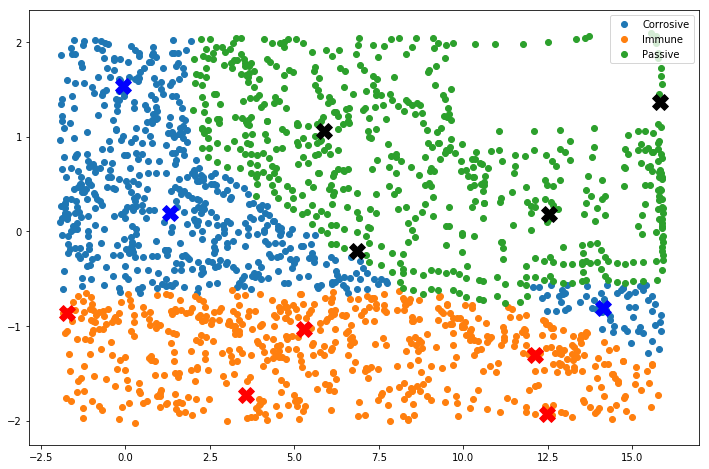

In [5]:
plt.rcParams["figure.figsize"] = (12,8)

plt.scatter(data_corrosive[:,0], data_corrosive[:,1], label = 'Corrosive')
plt.scatter(data_immune[:,0], data_immune[:,1], label = 'Immune')
plt.scatter(data_passive[:,0], data_passive[:,1], label = 'Passive')

## Add centers of Corrosive
for cs in centers_corrosive:
    plt.scatter(cs[0], cs[1], marker = 'X', color = 'blue', s = 250)

## Add centers of Immune
for cs in centers_immune:
    plt.scatter(cs[0], cs[1], marker = 'X', color = 'red', s = 250)
    
## Add centers of Passive
for cs in centers_passive:
    plt.scatter(cs[0], cs[1], marker = 'X', color = 'black', s = 250)
    

plt.legend();

### Checking different % of training data

In [ ]:
testing_errors = []
epoch_num_clusters = []
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for test_size in test_sizes:
    print('test_size')
    print(test_size)
    
    testing_error, num_clusters = apply_fuzzy_clustering_traing_test(df, test_size)
    testing_errors.append(testing_error)
    epoch_num_clusters.append(num_clusters)


test_size
0.1
Running QPSO...
Running testing...
test_size
0.2
Running QPSO...


In [ ]:
plt.bar(testing_errors)

In [ ]:
epoch_num_clusters

## Applying another fuzzy c-mean